In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:


!unzip -q "/content/drive/My Drive/color.zip" -d "/content/drive/My Drive/color_new"


In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/My Drive/color_new/color'
width=224
height=224
depth=3

In [ ]:
#Conversion of image to array

def convert_image_to_array (image_dir):
  try:
    image = cv2.imread (image_dir)
    if image is not None:
      image = cv2.resize (image, default_image_size)
      return img_to_array(image)
    else:
      return np.array([])
  except Exception as e:
    print ("Exception:", e)
    return None


In [ ]:
image_ls =[]
label_ls = []

try:
  print ("Loading images")
  root = listdir (directory_root)
  for folder in root:
    if folder==".idea":
      root.remove(folder)
  for plant_disease_folder in root:
    print (f"[INFO] Processing {plant_disease_folder} ...")
    plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}/")
    #print (plant_disease_image_list)
    image_list = listdir (f"{directory_root}/{plant_disease_folder}/")
    for single_image in image_list [:500]:
      image_dir = f"{directory_root}/{plant_disease_folder}/{single_image}"
      if image_dir.endswith(".jpg") == True or image_dir.endswith(".JPG") == True:
        image_ls.append(convert_image_to_array(image_dir))
        label_ls.append(plant_disease_folder)
  print("[INFO] Image loading completed") 
except Exception as e:
    print(f"Error : {e}")



Loading images
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Spider_mites Two-spotted_spider_mite ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Tomato___Tomato_mosaic_virus ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Image loading completed


In [ ]:
img_size = len (image_ls)

In [ ]:
#Transform image labels 

labelbinarizer = LabelBinarizer()
img_labels = labelbinarizer.fit_transform (label_ls)
pickle.dump (labelbinarizer, open('LabelTransform.pkl', 'wb'))
no_of_classes = len(labelbinarizer.classes_)
print (no_of_classes)
print (labelbinarizer.get_params)

15
<bound method BaseEstimator.get_params of LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)>


In [ ]:
print (labelbinarizer.classes_)

['Pepper,_bell___Bacterial_spot' 'Pepper,_bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy']


In [ ]:
print (image_ls[:10])

[array([[[180., 176., 181.],
        [183., 178., 184.],
        [177., 173., 178.],
        ...,
        [172., 168., 174.],
        [177., 173., 179.],
        [176., 172., 178.]],

       [[179., 175., 181.],
        [183., 179., 184.],
        [180., 176., 181.],
        ...,
        [173., 169., 175.],
        [174., 170., 176.],
        [174., 169., 175.]],

       [[165., 161., 166.],
        [173., 169., 174.],
        [179., 175., 180.],
        ...,
        [169., 165., 171.],
        [168., 164., 170.],
        [168., 164., 170.]],

       ...,

       [[132., 129., 141.],
        [112., 108., 120.],
        [112., 108., 120.],
        ...,
        [111., 107., 118.],
        [108., 104., 115.],
        [110., 106., 117.]],

       [[127., 123., 135.],
        [107., 103., 115.],
        [117., 113., 125.],
        ...,
        [102.,  98., 109.],
        [120., 116., 127.],
        [ 99.,  95., 106.]],

       [[125., 121., 133.],
        [123., 119., 131.],
        [123., 

In [ ]:
np_img_list = np.array (image_ls, dtype = np.float16) / 225.0

In [ ]:
#Splitting data into training and validation

x_train, x_val, y_train, y_val = train_test_split (np_img_list, img_labels, test_size = 0.2, random_state=42)

In [ ]:
aug = ImageDataGenerator (rotation_range = 25, width_shift_range = 0.1, height_shift_range = 0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest" )

In [ ]:
model = Sequential()
input_shape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=input_shape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(no_of_classes))
model.add(Activation("softmax"))

In [ ]:
from keras.callbacks import *

filepath = "/content/drive/My Drive/MyCustomCNN/epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"

checkpoint = ModelCheckpoint (filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)       

In [ ]:
optimizer = Adam (lr=INIT_LR, decay = INIT_LR/EPOCHS)

model.compile (loss="binary_crossentropy", optimizer = optimizer, metrics = ['accuracy'])
print ("Train...")

Train...


In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1,
    callbacks = callbacks_list
    )

Epoch 1/20
208/208 [==============================] - 849s 4s/step - loss: 0.1715 - accuracy: 0.9432 - val_loss: 0.6641 - val_accuracy: 0.8919

Epoch 00001: val_accuracy improved from -inf to 0.89193, saving model to /content/drive/My Drive/MyCustomCNN/epochs:001-val_accuracy:0.892.hdf5
Epoch 2/20
208/208 [==============================] - 855s 4s/step - loss: 0.1224 - accuracy: 0.9573 - val_loss: 0.6124 - val_accuracy: 0.8973

Epoch 00002: val_accuracy improved from 0.89193 to 0.89730, saving model to /content/drive/My Drive/MyCustomCNN/epochs:002-val_accuracy:0.897.hdf5
Epoch 3/20
208/208 [==============================] - 854s 4s/step - loss: 0.1070 - accuracy: 0.9619 - val_loss: 0.4636 - val_accuracy: 0.9171

Epoch 00003: val_accuracy improved from 0.89730 to 0.91708, saving model to /content/drive/My Drive/MyCustomCNN/epochs:003-val_accuracy:0.917.hdf5
Epoch 4/20
208/208 [==============================] - 859s 4s/step - loss: 0.0811 - accuracy: 0.9706 - val_loss: 0.2215 - val_accu

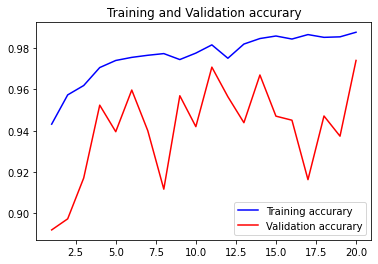

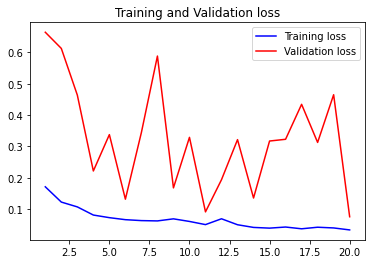

In [ ]:
accu = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accu) + 1)
#Train and validation accuracy
plt.plot(epochs, accu, 'b', label='Training accurary')
plt.plot(epochs, val_acc, 'r', label='Validation accurary')
plt.title('Training and Validation accurary')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_val, y_val)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
1665/1665 [==============================] - 56s 33ms/step
Test Accuracy: 97.40140438079834


In [ ]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model_15_20_epoch.pkl', 'wb'))

[INFO] Saving model...


In [ ]:
from google.colab import files
files.download("cnn_model_15.pkl")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 44694, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.applications import DenseNet169
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
directory_root = '/content/drive/My Drive/color_new/color'
width=224
height=224
depth=3

In [ ]:
def convert_image_to_array (image_dir):
  try:
    image = cv2.imread (image_dir)
    if image is not None:
      image = cv2.resize (image, default_image_size)
      return img_to_array(image)
    else:
      return np.array([])
  except Exception as e:
    print ("Exception:", e)
    return None

In [ ]:
image_ls =[]
label_ls = []

try:
  print ("Loading images")
  root = listdir (directory_root)
  for folder in root:
    if folder==".idea":
      root.remove(folder)
  for plant_disease_folder in root:
    print (f"[INFO] Processing {plant_disease_folder} ...")
    plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}/")
    #print (plant_disease_image_list)
    image_list = listdir (f"{directory_root}/{plant_disease_folder}/")
    for single_image in image_list [:300]:
      image_dir = f"{directory_root}/{plant_disease_folder}/{single_image}"
      if image_dir.endswith(".jpg") == True or image_dir.endswith(".JPG") == True:
        image_ls.append(convert_image_to_array(image_dir))
        label_ls.append(plant_disease_folder)
  print("[INFO] Image loading completed") 
except Exception as e:
    print(f"Error : {e}")

Loading images
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Spider_mites Two-spotted_spider_mite ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Tomato___Tomato_mosaic_virus ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Image loading completed


In [ ]:
img_size = len (image_ls)

In [ ]:
labelbinarizer = LabelBinarizer()
img_labels = labelbinarizer.fit_transform (label_ls)
pickle.dump (labelbinarizer, open('/content/drive/My Drive/LabelTransform.pkl', 'wb'))
no_of_classes = len(labelbinarizer.classes_)
print (no_of_classes)

15


In [ ]:
np_img_list = np.array (image_ls, dtype = np.float16) / 225.0

In [ ]:
x_train, x_val, y_train, y_val = train_test_split (np_img_list, img_labels, test_size = 0.2, random_state=42)

In [ ]:
aug = ImageDataGenerator (rotation_range = 25, width_shift_range = 0.1, height_shift_range = 0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest" )

In [ ]:
from keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from keras.models import Model

class Densenet:
    def __init__(self, loss, optmizer, metrics):
        self.loss = loss
        self.optimizer = optmizer
        self.metrics = metrics
    

    def create_model(self, output_space: int) :
        base_model = DenseNet169(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
        out0 = base_model.output
        out = GlobalMaxPooling2D()(out0)
        #out2 = GlobalAveragePooling2D()(out0)
        #out3 = Flatten()(out0)
        #out = Concatenate(axis=-1)([out1, out2, out3])
        out = Dropout(0.5)(out)
        
        predictions = Dense(output_space, activation="sigmoid")(out)
        
        model = Model(inputs=base_model.input, outputs=predictions)
        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
        #model.summary()
        return model

In [ ]:
from keras.callbacks import *

filepath = "/content/drive/My Drive/DenseNetCNN/epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.h5"

checkpoint = ModelCheckpoint (filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [ ]:
from keras import losses, optimizers

model = Densenet(
    losses.binary_crossentropy,
    optimizers.Adam(lr=10e-5),
    ["accuracy"]
).create_model(15)

51879936/51877672 [==============================] - 4s 0us/step


In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1,
    callbacks = callbacks_list
    )

Epoch 1/10
108/108 [==============================] - 2233s 21s/step - loss: 0.5225 - accuracy: 0.8693 - val_loss: 0.2501 - val_accuracy: 0.9494

Epoch 00001: val_accuracy improved from -inf to 0.94941, saving model to /content/drive/My Drive/DenseNetCNN/epochs:001-val_accuracy:0.949.h5
Epoch 2/10
108/108 [==============================] - 2056s 19s/step - loss: 0.1376 - accuracy: 0.9602 - val_loss: 0.0641 - val_accuracy: 0.9812

Epoch 00002: val_accuracy improved from 0.94941 to 0.98117, saving model to /content/drive/My Drive/DenseNetCNN/epochs:002-val_accuracy:0.981.h5
Epoch 3/10
108/108 [==============================] - 1959s 18s/step - loss: 0.0750 - accuracy: 0.9768 - val_loss: 0.0388 - val_accuracy: 0.9877

Epoch 00003: val_accuracy improved from 0.98117 to 0.98768, saving model to /content/drive/My Drive/DenseNetCNN/epochs:003-val_accuracy:0.988.h5
Epoch 4/10
108/108 [==============================] - 2047s 19s/step - loss: 0.0527 - accuracy: 0.9838 - val_loss: 0.0308 - val_ac

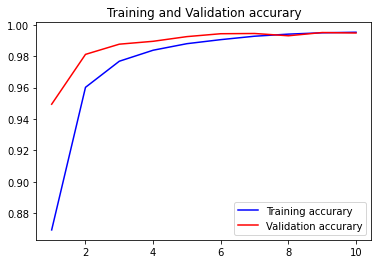

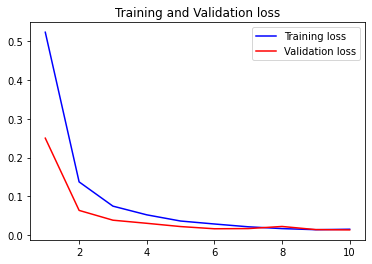

In [ ]:
accu = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accu) + 1)
#Train and validation accuracy
plt.plot(epochs, accu, 'b', label='Training accurary')
plt.plot(epochs, val_acc, 'r', label='Validation accurary')
plt.title('Training and Validation accurary')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
img_list = []
label_list=[]
try:
  print ("Loading image")
  root = listdir (directory_root)
  for folder in root:
    if folder==".idea":
      root.remove(folder)
  for plant_disease_folder in root[1:2]:
    print (f"[INFO] Processing {plant_disease_folder} ...")
    plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}/")
    #print (plant_disease_image_list)
    image_list = listdir (f"{directory_root}/{plant_disease_folder}/")
    for single_image in image_list [1:2]:
      image_dir = f"{directory_root}/{plant_disease_folder}/{single_image}"
      if image_dir.endswith(".jpg") == True or image_dir.endswith(".JPG") == True:
        img_list.append(convert_image_to_array(image_dir))
        label_list.append(plant_disease_folder)
  print("[INFO] Image loading completed") 
except Exception as e:
    print(f"Error : {e}")

Loading image
[INFO] Processing Pepper,_bell___healthy ...
[INFO] Image loading completed


In [ ]:
np_img_ls = np.array(img_list,dtype=np.float16) / 225.0

In [ ]:
import keras 

loaded_model = keras.models.load_model('/content/drive/My Drive/DenseNetCNN/epochs:007-val_accuracy:0.994.h5', compile=True)
print (loaded_model.layers[0].input_shape)
result = loaded_model.predict(np_img_ls)
print (np.argmax(result, axis=1))


(None, 224, 224, 3)
[1]


In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/PlantVillage/output'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = models.vgg13(pretrained=True)
print (list(list(model.classifier.children())[1].parameters()))
mod = list(model.classifier.children())
mod.pop()
mod.append(torch.nn.Linear(4096, 15))
new_classifier = torch.nn.Sequential(*mod)
print (list(list(new_classifier.children())[1].parameters()))
model.classifier = new_classifier
model = model.to(device)

[]
[]


In [ ]:
from torch.optim import lr_scheduler
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

model = train_model(model, nn.CrossEntropyLoss(), optimizer_ft, lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1),num_epochs=20)

Epoch 0/19
----------


KeyboardInterrupt: ignored

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sys
import os
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


# Any results you write to the current directory are saved as output.

# define cnn model
def define_model(in_shape=(224, 224, 3), out_shape=38):
	# load model
	model = VGG16(include_top=False, input_shape=in_shape, weights="imagenet")
	#model.load_weights('../input/VGG-16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    # mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	
	
	# allow last vgg block to be trainable
	model.get_layer('block5_conv1').trainable = True
	model.get_layer('block5_conv2').trainable = True
	model.get_layer('block5_conv3').trainable = True
	model.get_layer('block5_pool').trainable = True
	
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	fcon1 = Dense(4096, activation='relu', kernel_initializer='he_uniform')(flat1)
	fdrop1 = Dropout(0.25)(fcon1)
	fbn1 = BatchNormalization()(fdrop1)
	fcon2 = Dense(4096, activation='relu', kernel_initializer='he_uniform')(fbn1)
	fdrop2 = Dropout(0.25)(fcon2)
	fbn2 = BatchNormalization()(fdrop2)
	output = Dense(out_shape, activation='softmax')(fbn2)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.01, momentum=0.9,decay=0.005)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    sns.set()
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='valid')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Loss')
    pyplot.legend()
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='valid')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Accuracy')
    pyplot.legend()
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

# load and prepare the image for prediction
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
    #rescale
	img = img/255
	# center pixel data
	#img = img.astype('float32')
	#img = img - [123.68, 116.779, 103.939]
	return img    

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
                                   
valid_datagen = ImageDataGenerator(rescale=1./255)

training_iterator = train_datagen.flow_from_directory(traindir,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

test_iterator = valid_datagen.flow_from_directory(validdir,
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical')

class_dict = training_iterator.class_indices
print(class_dict)

class_labels = list(class_dict.keys())
print(class_labels)

train_num_samples = training_iterator.samples
valid_num_samples = test_iterator.samples
# define model
model = define_model()
model.summary()

weightsfilepath = "bestweights.hdf5"
checkpoint = ModelCheckpoint(weightsfilepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]
# fit model
history = model.fit_generator(training_iterator, steps_per_epoch=len(training_iterator),
		validation_data=test_iterator, validation_steps=len(test_iterator), epochs=8, callbacks=callbacks_list, verbose=2)


# evaluate model
_, acc = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=1)
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history)

#model.save('plantdisease_vgg19model.h5')

# load the image
img = load_image('../input/new-plant-diseases-dataset/test/test/AppleScab3.JPG')
print("Prediction for AppleScab3:")
#prediction will be an array of values; index corresp to max value will be used to get the class label
prediction = model.predict(img)
predicted_class_name = class_labels[np.argmax(prediction)]
print("Detected the leaf as ", predicted_class_name)     

for filename in os.listdir(testdir):
    #print(filename)
    # load the image
    filepath = testdir + '/' + filename
    #print(filepath)
    img = load_image(filepath)
    #prediction will be an array of values; index corresp to max value will be used to get the class label
    prediction = model.predict(img)
    predicted_class_name = class_labels[np.argmax(prediction)]
    print(filename, "  predicted as ", predicted_class_name)  

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=False, input_shape=(224,224,3), weights="imagenet")
model.summary()
for layer in model.layers[:9]:
  layer.trainable = False

optimizer = Adam (lr=INIT_LR, decay = INIT_LR/EPOCHS)

model.compile (loss="categorical_crossentropy", optimizer = optimizer, metrics = ['accuracy'])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model.layers

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.optimizers import SGD


model = VGG16(include_top=False, input_shape=(224,224,3), weights="imagenet")
for layer in model.layers:
	layer.trainable = False
	
	
model.get_layer('block5_conv1').trainable = True
model.get_layer('block5_conv2').trainable = True
model.get_layer('block5_conv3').trainable = True
model.get_layer('block5_pool').trainable = True

flat1 = Flatten()(model.layers[-1].output)
fcon2 = Dense(4096, activation='relu', kernel_initializer='he_uniform')(flat1)
fdrop2 = Dropout(0.25)(fcon2)
fbn2 = BatchNormalization()(fdrop2)
output = Dense(15, activation='softmax')(fbn2)
	# define new model
model = Model(inputs=model.inputs, outputs=output)
	# compile model
opt = SGD(lr=0.01, momentum=0.9,decay=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/MyCNN/epochs:015-val_accuracy:0.938.h5')
model.load_weights ('/content/drive/My Drive/MyCNN/epochs:015-val_accuracy:0.938.h5')

In [ ]:
from keras.callbacks import *

filepath = "/content/drive/My Drive/MyCNN/epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.h5"

checkpoint = ModelCheckpoint (filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=32),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // 32,
    initial_epoch=19,
    epochs=EPOCHS, verbose=1,
    callbacks = callbacks_list
    )

Epoch 20/25
175/175 [==============================] - 2232s 13s/step - loss: 0.1110 - accuracy: 0.9621 - val_loss: 0.3245 - val_accuracy: 0.9103

Epoch 00020: val_accuracy improved from -inf to 0.91032, saving model to /content/drive/My Drive/MyCNN/epochs:020-val_accuracy:0.910.h5
Epoch 21/25
  8/175 [>.............................] - ETA: 29:21 - loss: 0.1313 - accuracy: 0.9630

In [ ]:
directory_root = "/content/drive/My Drive/color_new/color"

In [ ]:
img_list = []
label_list=[]
default_image_size = ((256,256))
try:
  print ("Loading image")
  root = listdir (directory_root)
  for folder in root:
    if folder==".idea":
      root.remove(folder)
  for plant_disease_folder in root[3:4]:
    print (f"[INFO] Processing {plant_disease_folder} ...")
    plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}/")
    #print (plant_disease_image_list)
    image_list = listdir (f"{directory_root}/{plant_disease_folder}/")
    for single_image in image_list [:1]:
      image_dir = f"{directory_root}/{plant_disease_folder}/{single_image}"
      if image_dir.endswith(".jpg") == True or image_dir.endswith(".JPG") == True:
        img_list.append(convert_image_to_array(image_dir))
        label_list.append(plant_disease_folder)
  print("[INFO] Image loading completed") 
except Exception as e:
    print(f"Error : {e}")

Loading image
[INFO] Processing Potato___healthy ...
[INFO] Image loading completed


In [ ]:
np_img_lis = np.array (img_list, dtype = np.float16) / 225.0

In [ ]:
img_list

[array([[[151., 141., 158.],
         [126., 116., 133.],
         [157., 147., 164.],
         ...,
         [166., 157., 177.],
         [151., 142., 162.],
         [153., 144., 164.]],
 
        [[176., 166., 183.],
         [159., 149., 166.],
         [157., 147., 164.],
         ...,
         [147., 138., 158.],
         [168., 159., 179.],
         [186., 177., 197.]],
 
        [[184., 174., 191.],
         [158., 148., 165.],
         [160., 150., 167.],
         ...,
         [167., 158., 178.],
         [161., 152., 172.],
         [149., 140., 160.]],
 
        ...,
 
        [[124., 118., 141.],
         [140., 134., 157.],
         [151., 145., 168.],
         ...,
         [121., 125., 149.],
         [140., 144., 168.],
         [151., 155., 179.]],
 
        [[147., 141., 164.],
         [124., 118., 141.],
         [114., 108., 131.],
         ...,
         [175., 179., 203.],
         [130., 134., 158.],
         [120., 124., 148.]],
 
        [[108., 102., 125.],
 

In [ ]:
np_img_lis

array([[[[0.671 , 0.6265, 0.702 ],
         [0.56  , 0.5156, 0.5913],
         [0.6978, 0.6533, 0.729 ],
         ...,
         [0.738 , 0.6978, 0.7866],
         [0.671 , 0.6313, 0.72  ],
         [0.68  , 0.64  , 0.729 ]],

        [[0.782 , 0.738 , 0.8135],
         [0.7065, 0.662 , 0.738 ],
         [0.6978, 0.6533, 0.729 ],
         ...,
         [0.6533, 0.6133, 0.702 ],
         [0.7466, 0.7065, 0.7954],
         [0.8267, 0.7866, 0.8755]],

        [[0.818 , 0.7734, 0.849 ],
         [0.702 , 0.6577, 0.7334],
         [0.711 , 0.6665, 0.742 ],
         ...,
         [0.742 , 0.702 , 0.791 ],
         [0.7153, 0.676 , 0.7646],
         [0.662 , 0.622 , 0.711 ]],

        ...,

        [[0.5513, 0.5244, 0.6265],
         [0.622 , 0.5957, 0.6978],
         [0.671 , 0.6445, 0.7466],
         ...,
         [0.5376, 0.5557, 0.662 ],
         [0.622 , 0.64  , 0.7466],
         [0.671 , 0.689 , 0.7954]],

        [[0.6533, 0.6265, 0.729 ],
         [0.5513, 0.5244, 0.6265],
         [0.

In [ ]:
import keras
import numpy as np
from os import listdir

In [ ]:
#model = keras.models.load_model('/content/drive/My Drive/DenseNetCNN/epochs:009-val_accuracy:0.995.h5')
model = keras.models.load_model('/content/drive/My Drive/MyCustomCNN/epochs:020-val_accuracy:0.974.h5')
result = model.predict(np_img_lis)
print (np.argmax(result, axis=1))

[4]


OCCLUSION EXPERIMENT 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np

import keras

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
model = keras.models.load_model('/content/drive/My Drive/MyCustomCNN/epochs:020-val_accuracy:0.974.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)       

In [ ]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

IMAGE_PATH = "/content/drive/My Drive/color_new/color/Pepper,_bell___Bacterial_spot/0a0dbf1f-1131-496f-b337-169ec6693e6f___NREC_B.Spot 9241.JPG"
explainer = OcclusionSensitivity()
img_inp = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(256,256))
img_inp = convert_image_to_array(img_inp)
img_inp = np.array (img_inp, dtype = np.float16) / 225.0
grid = explainer.explain(([img_inp], None), model, 0, 7)
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(grid)

Exception: <built-in function imread> returned NULL without setting an error


IndexError: ignored

In [ ]:
!pip install tf-explain

     |████████████████████████████████| 51kB 4.1MB/s 


In [ ]:
import argparse
import math
import time

import matplotlib.pylab as plt
import seaborn as sns

#from model import *
from vis.utils import *


def get_occ_imgs(img, img_size, occ_size, occ_pixel, occ_stride, classes):
    # Get original image
    image = cv2.imread(img)
    image = cv2.resize(image, (img_size, img_size)).astype(np.float32)

    # Index of class with highest probability
    class_index = np.argmax(classes)
    print('True class index:', class_index)

    # Define number of occlusions in both dimensions
    output_height = int(math.ceil((img_size - occ_size) / occ_stride + 1))
    output_width = int(math.ceil((img_size - occ_size) / occ_stride + 1))
    print('Total iterations:', output_height, '*', output_width, '=', output_height * output_width)

    # Initialize probability heatmap and occluded images
    temp_img_list = []
    prob_matrix = np.zeros((output_height, output_width))

    start = time.time()

    for h in range(output_height):
        for w in range(output_width):
            # Occluder window:
            h_start = h * occ_stride
            w_start = w * occ_stride
            h_end = min(img_size, h_start + occ_size)
            w_end = min(img_size, w_start + occ_size)

            # Getting the image copy, applying the occluding window and classifying it:
            occ_image = image.copy()
            occ_image[h_start:h_end, w_start:w_end, :] = occ_pixel
            predictions = pred_prob_list(model, occ_image.copy())[0]
            prob = predictions[class_index]

            # Collect the probability value in a matrix
            prob_matrix[h, w] = prob

            # Collect occluded images   
            occ_image[h_start:h_end, w_start:w_end, :] = prob*255
            cv2.putText(img=occ_image, text=str(round(prob,4)), org=(w_start, int(h_start + (h_end - h_start) / 2)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, color=(255*(1-prob),255*(1-prob),255*(1-prob)), thickness=1)  
            cv2.imwrite('occ_exp/video/'+img_name+str(h*output_width+w+1).zfill(6)+'.png',occ_image) 
            
            # To save occluded images as a video, run the following shell command
            """ffmpeg -framerate 5 -i occ_exp/video/<img_name>%06d.jpg -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p occ_exp/<img_name>.mp4"""

            temp_img_list.append(occ_image)

        print('Percentage done :', round(((h + 1) * output_width) * 100 / (output_height * output_width), 2), '%')

    end = time.time()
    elapsed = end - start
    print('Total time taken:', elapsed, 'sec\tAverage:', elapsed / (output_height * output_width), 'sec')

    # Save probabilities and all occluded images in one
    np.save('occ_exp/probs_' + img_name + '.npy', prob_matrix)
    # save_occs(temp_img_list, img_size, img_size, img_path.split('/')[-1])

    return prob_matrix


def regularize(prob, norm, percentile):
    # First save the original prob matrix as heat-map
    f = plt.figure(1)
    sns.heatmap(prob, xticklabels=False, yticklabels=False)
    f.savefig('occ_exp/heatmap_' + img_path.split('/')[-1])

    # Apply Regularization
    prob = normalize_clip(prob) if norm else prob
    clipped = clip_weak_pixel_regularization(prob, percentile=percentile)
    reg_heat = blur_regularization(1 - clipped, size=(3, 3))

    # Save regularized heat-map
    f2 = plt.figure(2)
    sns.heatmap(reg_heat, xticklabels=False, yticklabels=False)
    f2.savefig('occ_exp/heatmap_reg_' + img_path.split('/')[-1])

    return reg_heat


def join(heat_reg, img, img_size, occ_size):
    # Get original image
    image = cv2.imread(img, 1)
    inp_img = cv2.resize(image, (img_size, img_size))

    H, W = image.shape[0], image.shape[1]
    bord = int(occ_size / 2)

    # Define heat-map to be projected on original image
    heat_map = cv2.resize(heat_reg,(img_size, img_size)).astype(np.float32)
    
    # Second way to define heat-map - manually set border values
    # heat_map = np.zeros((img_size, img_size))
    # heat_map[bord:img_size - bord, bord:img_size - bord] = cv2.resize(heat_reg,
    #     (img_size - occ_size, img_size - occ_size)).astype(np.float32)
    # np.place(heat_map, heat_map == 0.0, np.median(heat_map))

    # Third way to define heat-map - replicate border values
    # heatmap = cv2.resize(heat, (img_size-occ_size, img_size-occ_size)).astype(np.float32)
    # heatmap = cv2.copyMakeBorder(heat-map,bord,bord,bord,bord,cv2.BORDER_REPLICATE)


    # Original image * heat-map
    for i in range(3):
        inp_img[:, :, i] = heat_map * inp_img[:, :, i]
    inp_viz = cv2.resize(inp_img, (W, H))

    # Save the final output
    cv2.imwrite('occ_exp/final_' + img.split('/')[-1], inp_viz)

    return inp_viz


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--img', type=str, default=IMAGE_PATH)  # Path of the input image
    parser.add_argument('--weights_path', type=str, default='/content/drive/My Drive/DenseNetCNN/epochs:006-val_accuracy:0.994.h5')  # Path of the saved pre-trained model
    parser.add_argument('--size', type=int, default='224')  # Layer name
    parser.add_argument('--occ_size', type=int, default='40')  # Size of occluding window
    parser.add_argument('--pixel', type=int, default='0')  # Occluding window - pixel values
    parser.add_argument('--stride', type=int, default='5')  # Occlusion Stride
    parser.add_argument('--norm', type=int, default='1')  # Normalize probabilities first
    parser.add_argument('--percentile', type=int, default='25')  # Regularization percentile for heatmap
    args = parser.parse_args()
    return args


def getvals():
    args = get_args()
    print('\n', args)

    img_path, img_size = args.img, args.size
    img_name = img_path.split('/')[-1].split('.')[0]
    occ_size, occ_pixel, occ_stride = args.occ_size, args.pixel, args.stride

    # Input pre-trained model, defined in model.py
    model = load_trained_model(args.weights_path)

    # Get original image
    input_image = cv2.imread(img_path)
    input_image = cv2.resize(input_image, (img_size, img_size)).astype(np.float32)

    # Get probability list and print top 5 classes
    result = pred_prob_list(model, input_image)
    de_result = decode_predictions(result)[0]
    print('\nPredicted: ', de_result)

    # Start occlusion experiment and store predicted probabilities in a file
    print('Running occlusion iterations (Class:', de_result[0][1], ') ...\n')
    probs = get_occ_imgs(img_path, img_size, occ_size, occ_pixel, occ_stride, result)

    # Get probabilities and apply regularization
    print('\nGetting probability heat-map and regularizing...')
    probs = np.load('occ_exp/probs_' + img_name + '.npy')
    heat = regularize(probs, args.norm, args.percentile)

    # Project heatmap on original image
    print('\nProject the heat-map to original image...')
    aug = join(heat, img_path, img_size, occ_size)

    print('\nDone')

getvals()


usage: ipykernel_launcher.py [-h] [--img IMG] [--weights_path WEIGHTS_PATH]
                             [--size SIZE] [--occ_size OCC_SIZE]
                             [--pixel PIXEL] [--stride STRIDE] [--norm NORM]
                             [--percentile PERCENTILE]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-31d90b01-377a-4115-ab8b-8f48b797b6ae.json


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


SALIENCY EXPERIMENT

In [ ]:
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
import keras
model = keras.models.load_model(weights_path)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
from vis.visualization import visualize_saliency
from vis.utils import utils
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [ ]:
import scipy

In [ ]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 147kB/s 
ERROR: umap-learn 0.4.3 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
import keras
import tensorflow as tf
import vis ## keras-vis
import matplotlib.pyplot as plt
import numpy as np
print("keras      {}".format(keras.__version__))
print("tensorflow {}".format(tf.__version__))

Using TensorFlow backend.


keras      2.3.1
tensorflow 2.2.0


In [ ]:
#model = keras.models.load_model('/content/drive/My Drive/DenseNetCNN/epochs:006-val_accuracy:0.994.h5')
print (vis.__version__)

AttributeError: ignored

In [ ]:
#model = keras.models.load_model('/content/drive/My Drive/MyCustomCNN/epochs:020-val_accuracy:0.974.h5')
model = keras.models.load_model('/content/drive/My Drive/MyCNN/epochs:015-val_accuracy:0.938.h5')

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
classlabel = ['Pepper,_bell___Bacterial_spot' 'Pepper,_bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy']

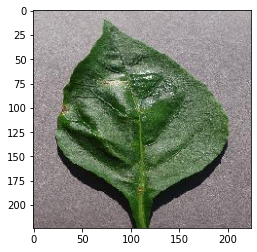

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
_img = load_img("/content/drive/My Drive/color_new/color/Pepper,_bell___Bacterial_spot/0a0dbf1f-1131-496f-b337-169ec6693e6f___NREC_B.Spot 9241.JPG",target_size=(224,224))
plt.imshow(_img)
plt.show()

In [ ]:
import cv2

def convert_image_to_array (image_dir):
  try:
    image = cv2.imread(image_dir)
    if image is not None:
      image = cv2.resize (image, (256,256))
      return img_to_array(image)
    else:
      return np.array([])
  except Exception as e:
    print ("Exception:", e)
    return None

In [ ]:
img = convert_image_to_array("/content/drive/My Drive/color_new/color/Pepper,_bell___Bacterial_spot/0a0dbf1f-1131-496f-b337-169ec6693e6f___NREC_B.Spot 9241.JPG")
image_ls = []
image_ls.append(img)
np_img_list = np.array (image_ls, dtype = np.float16) / 225.0
y_pred  = model.predict(np_img_list)
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
print (class_idxs_sorted[:5])

[ 0  4  1 12 11]


In [ ]:
from vis.utils import utils
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'activation_7')

In [ ]:
model.layers[layer_idx].activation = keras.activations.linear
model_new = utils.apply_modifications(model)

In [ ]:
from vis.visualization import visualize_saliency
print (img[np.newaxis,...])

class_idx = class_idxs_sorted[0]
grad_top1 = visualize_saliency(model_new,
                               layer_idx,
                               filter_indices = class_idx,
                               seed_input     = img[np.newaxis,...])

[[[[193. 192. 196.]
   [189. 188. 192.]
   [180. 179. 183.]
   ...
   [167. 165. 171.]
   [163. 161. 167.]
   [162. 160. 166.]]

  [[203. 202. 206.]
   [186. 185. 189.]
   [169. 168. 172.]
   ...
   [175. 173. 179.]
   [177. 175. 181.]
   [180. 178. 184.]]

  [[174. 173. 177.]
   [164. 163. 167.]
   [164. 163. 167.]
   ...
   [169. 167. 173.]
   [173. 171. 177.]
   [179. 177. 183.]]

  ...

  [[117. 115. 127.]
   [110. 108. 120.]
   [125. 123. 135.]
   ...
   [117. 113. 124.]
   [112. 108. 119.]
   [113. 109. 120.]]

  [[112. 110. 122.]
   [117. 115. 127.]
   [127. 125. 137.]
   ...
   [159. 155. 166.]
   [121. 117. 128.]
   [178. 174. 185.]]

  [[123. 121. 133.]
   [117. 115. 127.]
   [117. 115. 127.]
   ...
   [ 97.  93. 104.]
   [128. 124. 135.]
   [127. 123. 134.]]]]


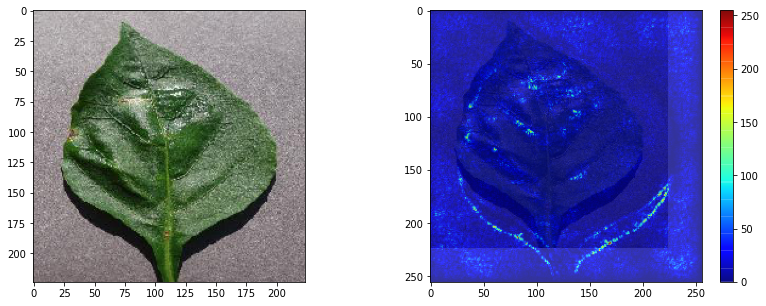

In [ ]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    axes[1].imshow(_img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    #plt.suptitle("Pr(class={}) = {:5.2f}".format(classlabel[class_idx],y_pred[0,class_idx]))
    plt.savefig('img.png')
plot_map(grad_top1)

In [ ]:
for class_idx in class_idxs_sorted[0:1]:
    grads  = visualize_saliency(model,
                               layer_idx,
                               filter_indices = class_idx,
                               seed_input     = img[np.newaxis,...],
                                )
    plot_map(grads)

AttributeError: ignored

In [ ]:
prediction=model.predict(np_img_list)
layer_idx = utils.find_layer_idx(model, 'activation_7')
model.layers[layer_idx].activation = keras.activations.linear
print("ritu1cnn")
model_new = utils.apply_modifications(model)
print("ritu2cnn")
#_img = load_img("./static/images/" + filename,target_size=(256,256))
class_idx = np.argmax(prediction, axis=1)
print(class_idx)
print(layer_idx)
print("ritu3cnn")
img_new = convert_image_to_array("/content/drive/My Drive/color_new/color/Pepper,_bell___Bacterial_spot/0a0dbf1f-1131-496f-b337-169ec6693e6f___NREC_B.Spot 9241.JPG")
print (img_new[np.newaxis,...])
grad_top1 = visualize_saliency(model_new,layer_idx,filter_indices = class_idx,seed_input     = img_new[np.newaxis,...])
print("ritu4cnn")

ritu1cnn
ritu2cnn
[0]
27
ritu3cnn
[[[[193. 192. 196.]
   [189. 188. 192.]
   [180. 179. 183.]
   ...
   [167. 165. 171.]
   [163. 161. 167.]
   [162. 160. 166.]]

  [[203. 202. 206.]
   [186. 185. 189.]
   [169. 168. 172.]
   ...
   [175. 173. 179.]
   [177. 175. 181.]
   [180. 178. 184.]]

  [[174. 173. 177.]
   [164. 163. 167.]
   [164. 163. 167.]
   ...
   [169. 167. 173.]
   [173. 171. 177.]
   [179. 177. 183.]]

  ...

  [[117. 115. 127.]
   [110. 108. 120.]
   [125. 123. 135.]
   ...
   [117. 113. 124.]
   [112. 108. 119.]
   [113. 109. 120.]]

  [[112. 110. 122.]
   [117. 115. 127.]
   [127. 125. 137.]
   ...
   [159. 155. 166.]
   [121. 117. 128.]
   [178. 174. 185.]]

  [[123. 121. 133.]
   [117. 115. 127.]
   [117. 115. 127.]
   ...
   [ 97.  93. 104.]
   [128. 124. 135.]
   [127. 123. 134.]]]]
ritu4cnn


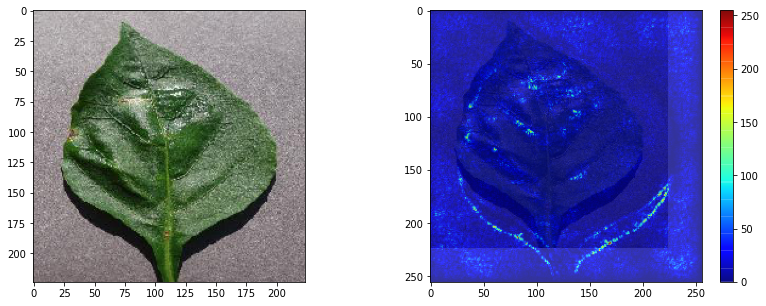

In [ ]:
plot_map(grad_top1)

PRECISION RECALL F1-SCORE 

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import keras

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/MyCustomCNN/epochs:020-val_accuracy:0.974.h5')
#model = keras.models.load_model('/content/drive/My Drive/MyCNN/epochs:015-val_accuracy:0.938.h5')
#model = keras.models.load_model('/content/drive/My Drive/DenseNetCNN/epochs:006-val_accuracy:0.994.h5')


In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(x_val, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1) #model.predict_classes(x_val, verbose=0)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]

In [ ]:
yhat_classes = np.argmax(yhat_probs, axis=1) #model.predict_classes(x_val, verbose=0)


In [ ]:
from sklearn.metrics import classification_report
rounded_labels = np.argmax(y_val, axis=1)

In [ ]:
rounded_labels[1]
y_val[1]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print(classification_report(rounded_labels, yhat_classes, digits=3))


              precision    recall  f1-score   support

           0      0.772     0.974     0.862       115
           1      1.000     0.784     0.879        88
           2      1.000     0.851     0.919       114
           3      0.812     0.978     0.888        93
           4      0.404     0.973     0.571        37
           5      0.934     0.755     0.835        94
           6      0.810     0.818     0.814        99
           7      0.960     0.750     0.842        96
           8      1.000     0.634     0.776       101
           9      0.776     0.667     0.717        99
          10      0.841     0.784     0.812        88
          11      0.860     0.734     0.792       109
          12      0.829     0.990     0.902        98
          13      0.728     0.971     0.832        69
          14      0.945     0.981     0.963       105

    accuracy                          0.836      1405
   macro avg      0.845     0.843     0.827      1405
weighted avg      0.867   

In [ ]:
from sklearn.metrics import confusion_matrix
print (confusion_matrix(rounded_labels, yhat_classes))

[[112   0   0   0   3   0   0   0   0   0   0   0   0   0   0]
 [  0  69   0   0  17   0   0   1   0   0   0   0   1   0   0]
 [  7   0  97   1   0   0   2   0   0   7   0   0   0   0   0]
 [  0   0   0  91   2   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1  36   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  71   2   0   0   0   2   5  14   0   0]
 [  4   0   0   3   0   5  81   1   0   0   0   2   2   1   0]
 [  2   0   0  14   0   0   2  72   0   3   1   1   1   0   0]
 [  2   0   0   0   2   0   3   1  64   8   7   2   1  11   0]
 [ 12   0   0   1   9   0   2   0   0  66   1   1   0   6   1]
 [  0   0   0   1   6   0   2   0   0   0  69   2   0   4   4]
 [  5   0   0   0  14   0   4   0   0   1   2  80   0   2   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0  97   1   0]
 [  0   0   0   0   0   0   2   0   0   0   0   0   0  67   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   1   0 103]]


In [ ]:
precision = precision_score(rounded_labels, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(rounded_labels, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(rounded_labels, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(rounded_labels, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(rounded_labels, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(rounded_labels, yhat_classes)
print(matrix)

ValueError: ignored